<a href="https://colab.research.google.com/github/kacper-dobrow/tensorflow-course/blob/main/08_intro_to_NLP_in_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language (e.g.: sequences of text or speech)

Another common term for NLP problems is sequence to sequence problems (seq2seq)

## Check for GPU

In [1]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


## Get helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2023-11-08 13:28:21--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-11-08 13:28:21 (69.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a text dataset
The dataset we'll be using is Kaggle's introduction to NLP dataset (text samples of Tweets labelled as disaster or not)

See the original source here:

https://www.kaggle.com/competitions/nlp-getting-started


In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
unzip_data("nlp_getting_started.zip")

--2023-11-08 13:28:28--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.203.207, 172.253.123.207, 142.250.97.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.203.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.006s  

2023-11-08 13:28:29 (92.9 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualize the data

Reading and writing files in Python:
https://realpython.com/read-write-files-python/

BUT you can use Pandas

Load and preprocess data in tf: https://www.tensorflow.org/tutorials/load_data/csv?hl=pl

In [4]:
import pandas as pd
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Shuffle training df
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [6]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
# How many examples of each class - balanced or not
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In case the data was more imbalanced:

https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=pl

In [8]:
# how many total smaples are there
len(train_df), len(test_df)

(7613, 3263)

In [9]:
# Visualize random training samples
import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text","target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}","(real disaster)" if target>0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real disaster)
Text:
Episcopal priests on road trip with interracial family shares harrowing story of police harassment http://t.co/RG4JIsHyBs via @dailykos

---

Target: 0 (not real disaster)
Text:
Good diss bad beat and flow. Mark my words Meek Mill is body bagging him once he responds. Patient patient. Meek is a battle rapper!

---

Target: 1 (real disaster)
Text:
World War II book LIGHTNING JOE An Autobiography by General J. Lawton Collins http://t.co/R4khEH7iaf http://t.co/qSZgJfUutu

---

Target: 0 (not real disaster)
Text:
If I could I would have been by at work but got injured and we have security concerns they must settle. This is torture.

---

Target: 1 (real disaster)
Text:
Fears over missing migrants in Med: Rescuers search for survivors after a boat carrying as many as 600 migrant... http://t.co/gx9sKUAu9J

---



### Split data into training and validation datasets



In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # use 10% of data for validation split
                                                                            random_state=42)

In [12]:
# Check the lengths
len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

In [13]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into numbers

Tokenization, Embedding

Word2vec embedding:
http://jalammar.github.io/illustrated-word2vec/

In [14]:
train_sentences[:10]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk',
       '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
       'destroy the free fandom honestly',
       'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
       '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
       'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
      dtype=object)

In [15]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary/dictionary. If none, there's no cap on the size of the vocabulary. If set to an integer, every word that doesn't fit into the dictionary is tokenized as <OOV>
                                    standardize="lower_and_strip_punctuation", # turns all uppercase to lowercase and removes dots, spaces etc
                                    split="whitespace", # text is split into tokens with whitespace
                                    ngrams=None, # whether to arrange text into n-word groups
                                    output_mode="int", # assigns an int token to every word
                                    output_sequence_length=None, # converts every string into a sequence of the same length - the length of the longest sequence - and adds 0's at the end if words are absent
                                    pad_to_max_tokens=False)

In [16]:
len(train_sentences[0].split())

7

In [17]:
# Find the average number of tokens in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [18]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words in the vocabulary
max_length =15 # how many words in a tweet does the model see

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length) # the vectorizer truncates or pads the tweets to this length

In [19]:
# fit the text vectorizer (it should be called tokenizer) to the training set
text_vectorizer.adapt(train_sentences)

In [20]:
# Create a sample sentence and vectorize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [21]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
        \n\nVectorized version:\n{text_vectorizer([random_sentence])}")

Original text:
What a feat! Watch the #BTS of @kallemattson's incredible music video for #Avalanche: https://t.co/3W6seA9tuv ????        

Vectorized version:
[[  55    3 1210  135    2 4055    6    1 2084  571   72   10  611    1
     0]]


In [22]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f"Number of words in vocabulary: {len(words_in_vocab)}")
print(f"5 most common words: \n{top_5_words}")

Number of words in vocabulary: 10000
5 most common words: 
['', '[UNK]', 'the', 'a', 'in']


### Creating an embedding using an embedding layer
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

Most cared for parameters in the embedding layer
* `input_dim` = the size of the vocabulary
* `output_dim` = the size of our output embedding vector
* `input_length` = length of sequences being passed into the embedding layer

In [23]:
from tensorflow.keras import layers
embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape to the size of our vocabulary
                             output_dim=128, # GPUs work good with multiples of 8
                             input_length=max_length) # how long is each input

In [24]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
        \n\nEmbedded version:\n{embedding(text_vectorizer(random_sentence))}")

Original text:
7.Beyonce Is my pick for http://t.co/thoYhrHkfJ Fan Army #Beyhive http://t.co/WvJ39a3BGM        

Embedded version:
[[ 0.04513116  0.00205511  0.03895572 ...  0.00622993  0.0263812
   0.02262941]
 [-0.01615119 -0.00323134  0.02865938 ... -0.0042581   0.02440608
   0.00307224]
 [ 0.02334488 -0.00669049 -0.04036763 ... -0.00422722 -0.0260445
   0.04951962]
 ...
 [ 0.0382424  -0.01567831  0.00062106 ... -0.0283631   0.00584413
  -0.04247838]
 [ 0.0382424  -0.01567831  0.00062106 ... -0.0283631   0.00584413
  -0.04247838]
 [ 0.0382424  -0.01567831  0.00062106 ... -0.0283631   0.00584413
  -0.04247838]]


In [25]:
# Check out a single token's embedding
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 0.04513116,  0.00205511,  0.03895572,  0.03900779, -0.02257495,
        0.00655293, -0.0390229 ,  0.0251841 , -0.01057702, -0.03495344,
        0.04011312, -0.02979937,  0.02821967, -0.04406228,  0.00220711,
       -0.01837528,  0.03814899,  0.0184266 ,  0.0251637 , -0.00480902,
        0.02691383,  0.01094414, -0.01775337,  0.04681234,  0.03270913,
       -0.04718345,  0.02664366,  0.01520859,  0.04359211,  0.00143836,
        0.03094054, -0.0370352 , -0.03340678, -0.04617219, -0.01125376,
        0.04433665, -0.04870548, -0.02390953, -0.02813428,  0.02145198,
        0.04231441,  0.02001259,  0.00395467, -0.04615352,  0.01552073,
        0.03074596, -0.01712815,  0.04178044, -0.02977388, -0.03188833,
        0.02203269,  0.00117069, -0.04211171, -0.0173417 ,  0.01028752,
       -0.04368929, -0.0107242 , -0.04632398, -0.01886784,  0.04853121,
        0.00300425, -0.00126624,  0.00298176,  0.00127784,  0.04354806,
        0.014250

In [26]:
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.04513116,  0.00205511,  0.03895572,  0.03900779, -0.02257495,
         0.00655293, -0.0390229 ,  0.0251841 , -0.01057702, -0.03495344,
         0.04011312, -0.02979937,  0.02821967, -0.04406228,  0.00220711,
        -0.01837528,  0.03814899,  0.0184266 ,  0.0251637 , -0.00480902,
         0.02691383,  0.01094414, -0.01775337,  0.04681234,  0.03270913,
        -0.04718345,  0.02664366,  0.01520859,  0.04359211,  0.00143836,
         0.03094054, -0.0370352 , -0.03340678, -0.04617219, -0.01125376,
         0.04433665, -0.04870548, -0.02390953, -0.02813428,  0.02145198,
         0.04231441,  0.02001259,  0.00395467, -0.04615352,  0.01552073,
         0.03074596, -0.01712815,  0.04178044, -0.02977388, -0.03188833,
         0.02203269,  0.00117069, -0.04211171, -0.0173417 ,  0.01028752,
        -0.04368929, -0.0107242 , -0.04632398, -0.01886784,  0.04853121,
         0.00300425, -0.00126624,  0.00298176,  0.00127784,  0.04354806,
  

## Modelling a text dataset

https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

* Model 0: Naive Bayes
* Model 1: Feed-forward NN
* Model 2: LSTM
* Model 3: GRU
* Model 4: Bidirectional-LSTM
* Model 5: 1D CNN
* Model 6: TFHub pretrained feature extractor
* Model 7: Same as 6 but with 10% data

### Model 0: Baseline

Create a baseline as a benchmark for our future experiments

We'll use SKLearn's Multinomial Naive Bayes using the TF-IDF formula to convert words to numbers

First we use non-deep-learning model as a reference because of its speed. Next we use deep learning models to improve the performance.

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization pipeline (equivalent to keras.Sequential)
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(train_sentences,train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [28]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels) # Equivalent to keras .evaluate method
print(f"Baseline model achieves accuracy of: {baseline_score*100:.2f}%")

Baseline model achieves accuracy of: 79.27%


In [29]:
# Make predictions
model_0_preds = model_0.predict(val_sentences) # just like in keras

### Create a function for comparing performance

We evaluate
* Accuracy
* Precision
* Recall
* F1-score

https://scikit-learn.org/stable/modules/model_evaluation.html


In [30]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1-score of a binary classification
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred)
  # Calculate model precision, recall and f1-score using "weighted" average to account for label imbalance
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}
  return model_results

In [31]:
# get baseline results
model_0_results = calculate_results(val_labels, model_0_preds)
model_0_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 1: Feed-forward dense model

In [32]:
# Create a tensorboard callback
from helper_functions import create_tensorboard_callback

# Create a directory to save tensorboard logs
SAVE_DIR = "model_logs"

In [33]:
# Build a functional API
import tensorflow as tf
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) # Inputs are 1D strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the vectorized inputs
x = layers.GlobalAveragePooling1D()(x) # Reduce dimensionality
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs,outputs, name="model_1_dense")

In [34]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [35]:
# Compile the model
model_1.compile(optimizer=tf.optimizers.Adam(),
                loss="binary_crossentropy",
                metrics=["accuracy"])

In [36]:
# Fit the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20231108-132832
Epoch 1/5
215/215 [==============================] - 11s 36ms/step - loss: 0.6116 - accuracy: 0.6907 - val_loss: 0.5347 - val_accuracy: 0.7559
Epoch 2/5
215/215 [==============================] - 8s 35ms/step - loss: 0.4417 - accuracy: 0.8194 - val_loss: 0.4718 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 6s 30ms/step - loss: 0.3478 - accuracy: 0.8608 - val_loss: 0.4590 - val_accuracy: 0.7953
Epoch 4/5
215/215 [==============================] - 5s 23ms/step - loss: 0.2855 - accuracy: 0.8910 - val_loss: 0.4656 - val_accuracy: 0.7927
Epoch 5/5
215/215 [==============================] - 4s 20ms/step - loss: 0.2381 - accuracy: 0.9105 - val_loss: 0.4776 - val_accuracy: 0.7808


In [37]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 2ms/step - loss: 0.4776 - accuracy: 0.7808


[0.47759854793548584, 0.7808399200439453]

In [38]:
# Make some predictions
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

24/24 [==============================] - 0s 2ms/step


(762, 1)

In [39]:
model_1_pred_probs[:10]

array([[0.42046097],
       [0.8466268 ],
       [0.99758744],
       [0.11301163],
       [0.14748755],
       [0.94533116],
       [0.9139011 ],
       [0.99347335],
       [0.9660455 ],
       [0.2640835 ]], dtype=float32)

In [40]:
# Convert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))

In [41]:
# Calculate model_1 results
model_1_results = calculate_results(val_labels,model_1_preds)
model_1_results

{'accuracy': 0.7808398950131233,
 'precision': 0.7841274438015813,
 'recall': 0.7808398950131233,
 'f1': 0.7782630349987989}

In [42]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(model_0_results.values()))

array([False, False, False, False])

Baseline is doing better

## Visualize learned embeddings

In [43]:
# Get the vocabulary from the text tokenization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [44]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [45]:
# Get the weight matirx of embedding layer
embed_weights = model_1.get_layer("embedding").get_weights()[0]
embed_weights.shape

(10000, 128)

Let's see how we can visualize it

https://projector.tensorflow.org/

https://www.tensorflow.org/text/guide/word_embeddings?hl=pl

In [46]:
# Create embedding files
import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()


In [47]:
# Download foles from colab to import to projector
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Recurrent neural networks (RNNs)

RNNs are useful for sequence data

The premise of a recurrent neural network is to use the representation of a previous input to aid the  representation of the later input.

https://www.youtube.com/watch?v=qjrad0V0uJE

https://colah.github.io/posts/2015-08-Understanding-LSTMs/

http://karpathy.github.io/2015/05/21/rnn-effectiveness/

### Model 2: LSTM

LSTM - long short term memory

https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

In [48]:
# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.LSTM(64, return_sequences=True)(x) # when stacking recurrent layers you need to set return_sequences to True. Otherwise the layer reduces dimensions
x = layers.LSTM(64)(x)
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [49]:
# Get s aummary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [50]:
# Compile
model_2.compile(optimizer="Adam",
                loss="binary_crossentropy",
                metrics=["accuracy"])

In [51]:
# Fit the model
history_model_2 = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,"model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20231108-132919
Epoch 1/5
215/215 [==============================] - 11s 39ms/step - loss: 0.2189 - accuracy: 0.9245 - val_loss: 0.5492 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 7s 34ms/step - loss: 0.1577 - accuracy: 0.9429 - val_loss: 0.5602 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 7s 33ms/step - loss: 0.1295 - accuracy: 0.9523 - val_loss: 0.6391 - val_accuracy: 0.7835
Epoch 4/5
215/215 [==============================] - 8s 36ms/step - loss: 0.1036 - accuracy: 0.9602 - val_loss: 0.8341 - val_accuracy: 0.7756
Epoch 5/5
215/215 [==============================] - 7s 32ms/step - loss: 0.0841 - accuracy: 0.9679 - val_loss: 0.9272 - val_accuracy: 0.7730


In [52]:
# Make predictions with model 2
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 1s 8ms/step


array([[1.8749136e-03],
       [5.8543324e-01],
       [9.9977905e-01],
       [5.6698773e-02],
       [7.4640807e-04],
       [9.9827981e-01],
       [8.3938980e-01],
       [9.9985015e-01],
       [9.9970448e-01],
       [5.7085711e-01]], dtype=float32)

In [53]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [54]:
# Calculate model 2 results
model_2_results = calculate_results(val_labels,
                                    model_2_preds)
model_2_results

{'accuracy': 0.7729658792650919,
 'precision': 0.7770640736660165,
 'recall': 0.7729658792650919,
 'f1': 0.7698502254147366}

### Model 3: GRU

Gated recurrent unit (GRU) has similar features to LSTM but less trainable parameters

https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be

In [55]:
# Create the same model but with a GRU cell
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.GRU(64, return_sequences=True)(x)
# x = layers.LSTM(64, return_sequences=True)(x)
x = layers.GRU(64)(x) # if wished to stack recurrent layers, set return_sequences=True
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [56]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1317313 (5.03 MB)
Trainable params: 1317313 (5.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [57]:
# Compile the model
model_3.compile(optimizer="Adam",
                loss="binary_crossentropy",
                metrics=["accuracy"])

In [58]:
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,"model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20231108-133004
Epoch 1/5
215/215 [==============================] - 11s 40ms/step - loss: 0.1601 - accuracy: 0.9358 - val_loss: 0.8551 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 7s 34ms/step - loss: 0.0822 - accuracy: 0.9707 - val_loss: 0.8686 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 8s 36ms/step - loss: 0.0715 - accuracy: 0.9724 - val_loss: 0.9494 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 7s 32ms/step - loss: 0.0611 - accuracy: 0.9745 - val_loss: 0.9149 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 8s 40ms/step - loss: 0.0525 - accuracy: 0.9766 - val_loss: 1.2306 - val_accuracy: 0.7743


In [59]:
# Make predictions
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 1s 5ms/step


array([[1.7625310e-02],
       [8.3331913e-01],
       [9.9994671e-01],
       [5.0341390e-02],
       [7.2869909e-05],
       [9.9987048e-01],
       [9.5861334e-01],
       [9.9996978e-01],
       [9.9994195e-01],
       [9.7932261e-01]], dtype=float32)

In [60]:
# Convert pred probs to preds
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [61]:
# Calculate model 3 results
model_3_results = calculate_results(val_labels, model_3_preds)
model_3_results

{'accuracy': 0.7742782152230971,
 'precision': 0.7743239391456158,
 'recall': 0.7742782152230971,
 'f1': 0.7732392305682255}

### Model 4: Bidirectional RNN

Bidirectional RNN feeds the representation of the former as well as the latter element in the sentence to the representation of the current element

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional

In [62]:
# Create the model
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
# x = layers.Bidirectional(layers.GRU(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs)

In [63]:
# Get the summary
model_4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable params: 1378945 (5.

In [64]:
# Compile model
model_4.compile(optimizer="Adam",
                loss="binary_crossentropy",
                metrics=["accuracy"])

In [65]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,"model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20231108-133048
Epoch 1/5
215/215 [==============================] - 16s 51ms/step - loss: 0.1014 - accuracy: 0.9701 - val_loss: 0.9255 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 10s 46ms/step - loss: 0.0542 - accuracy: 0.9785 - val_loss: 1.1852 - val_accuracy: 0.7743
Epoch 3/5
215/215 [==============================] - 10s 46ms/step - loss: 0.0456 - accuracy: 0.9793 - val_loss: 1.3119 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 9s 42ms/step - loss: 0.0450 - accuracy: 0.9790 - val_loss: 1.2338 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 9s 43ms/step - loss: 0.0394 - accuracy: 0.9810 - val_loss: 1.6914 - val_accuracy: 0.7782


In [66]:
# Make predictions
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 8ms/step


array([[6.7383708e-03],
       [9.8208994e-01],
       [9.9998969e-01],
       [2.3827703e-01],
       [8.2890392e-06],
       [9.9987108e-01],
       [9.9633694e-01],
       [9.9999309e-01],
       [9.9999040e-01],
       [9.9923402e-01]], dtype=float32)

In [67]:
# Convert to pred labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [68]:
# Calculate the results
model_4_results = calculate_results(val_labels,model_4_preds)
model_4_results

{'accuracy': 0.7782152230971129,
 'precision': 0.7794151013007613,
 'recall': 0.7782152230971129,
 'f1': 0.7765058443845926}

https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

##  CNN for text and other sequences

Typical structure
`Inputs -> Tokenization -> Embedding -> Conv1D -> Outputs`

### Model 5: Conv1D

In [69]:
# Test the embedding layer, Conv1D and pooling layer
from tensorflow.keras import layers
embedding_test = embedding(text_vectorizer(["this is a test sequence"])) # turn target sequence into an embedding matrix
conv1d = layers.Conv1D(filters=32,
                       kernel_size=5,
                       strides=1 # default
                       activation="relu",
                       padding="valid") # default
conv1D_test = conv1d(embedding_test) # pass the embedding through a conv1d layer
max_pool = layers.GlobalMaxPool1D()
max_pool_test = max_pool(conv1D_test) # get the max from the previous layer

embedding_test.shape, conv1D_test.shape, max_pool_test.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t

In [70]:
# Start constructing the model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_conv1d")

# Compile the model
model_5.compile(optimizer="Adam",
                loss="binary_crossentropy",
                metrics=["accuracy"])

# Get a summary
model_5.summary()

Model: "model_5_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 1)              

In [71]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_5_conv1d")])

Saving TensorBoard log files to: model_logs/model_5_conv1d/20231108-143000
Epoch 1/5
215/215 [==============================] - 9s 33ms/step - loss: 0.1252 - accuracy: 0.9584 - val_loss: 0.8881 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 5s 23ms/step - loss: 0.0728 - accuracy: 0.9729 - val_loss: 1.0408 - val_accuracy: 0.7664
Epoch 3/5
215/215 [==============================] - 7s 31ms/step - loss: 0.0601 - accuracy: 0.9766 - val_loss: 1.1343 - val_accuracy: 0.7585
Epoch 4/5
215/215 [==============================] - 7s 34ms/step - loss: 0.0553 - accuracy: 0.9768 - val_loss: 1.1842 - val_accuracy: 0.7585
Epoch 5/5
215/215 [==============================] - 9s 41ms/step - loss: 0.0517 - accuracy: 0.9784 - val_loss: 1.2319 - val_accuracy: 0.7598


In [72]:
# Make some predictions
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:5]

24/24 [==============================] - 0s 4ms/step


array([[1.8774928e-01],
       [9.5721042e-01],
       [9.9997044e-01],
       [1.8135734e-02],
       [9.3780521e-09]], dtype=float32)

In [73]:
# Convert probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 1., 0., 0.], dtype=float32)>

In [74]:
# Evaluate model 5 results
model_5_results = calculate_results(val_labels, model_5_preds)
model_5_results

{'accuracy': 0.7598425196850394,
 'precision': 0.7602880613964507,
 'recall': 0.7598425196850394,
 'f1': 0.7582369337868397}

## Transfer learning for NLP

https://huggingface.co/transformers/v3.0.2/index.html

### Model 6: TensorFlow Hub pretrained sentence encoder
https://tfhub.dev/google/universal-sentence-encoder/4

In [75]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                       "When you use the universal sentence encoder on a sentence, it turns it into numbers"]) # does tokenization for us
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157025  0.02485911  0.02878051 -0.012715    0.03971541  0.08827761
  0.02680988  0.05589838 -0.01068731 -0.00597293  0.00639321 -0.01819516
  0.00030816  0.09105889  0.05874645 -0.03180629  0.01512474 -0.05162925
  0.00991366 -0.06865345 -0.04209306  0.0267898   0.03011009  0.00321065
 -0.00337968 -0.04787356  0.0226672  -0.00985927 -0.04063615 -0.01292093
 -0.04666382  0.05630299 -0.03949255  0.00517682  0.02495827 -0.07014439
  0.0287151   0.0494768  -0.00633978 -0.08960193  0.02807119 -0.00808364
 -0.01360601  0.05998649 -0.10361788 -0.05195372  0.00232958 -0.02332531
 -0.03758106  0.03327729], shape=(50,), dtype=float32)


In [76]:
embed_samples[0].shape

TensorShape([512])

In [77]:
# Create keras layer using the pretrained layer from tf hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # blank bc the input to thr layer can be of variable length
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [87]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile
model_6.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="binary_crossentropy",
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [88]:
# Train the classifier on top of the USE embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_6_USE")])

Saving TensorBoard log files to: model_logs/model_6_USE/20231108-150430
Epoch 1/5
215/215 [==============================] - 6s 17ms/step - loss: 0.4997 - accuracy: 0.7876 - val_loss: 0.4508 - val_accuracy: 0.7979
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.4145 - accuracy: 0.8149 - val_loss: 0.4388 - val_accuracy: 0.8123
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4019 - accuracy: 0.8210 - val_loss: 0.4344 - val_accuracy: 0.8136
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3930 - accuracy: 0.8282 - val_loss: 0.4292 - val_accuracy: 0.8163
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3869 - accuracy: 0.8310 - val_loss: 0.4282 - val_accuracy: 0.8150


In [89]:
# Make predictions with the USE model
model_6_pred_probs = model_6.predict(val_sentences)
# Convert to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))

24/24 [==============================] - 1s 21ms/step


In [90]:
# Calculate results
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 0.8149606299212598,
 'precision': 0.8169586293569981,
 'recall': 0.8149606299212598,
 'f1': 0.8135344618830033}

## Model 7: TF Hub USE but only on 10% of data

In [121]:
# Create subsets of 10% of training data
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]
len(train_sentences_10_percent), len(train_labels_10_percent)

(685, 685)

In [122]:
# Check if the subset is representative
pd.Series(train_labels_10_percent).value_counts()

0    406
1    279
dtype: int64

To clone a model without learned weights you can use the tf.keras.models.clone_model function

https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model

In [123]:
# Create model by tf.keras.models.clone_model function
model_7 = tf.keras.models.clone_model(model_6)

# Compile the model
model_7.compile(optimizer="Adam",
                loss="binary_crossentropy",
                metrics=["accuracy"])

model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [124]:
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_7_USE_10_percent_correct_split")])

Saving TensorBoard log files to: model_logs/model_7_USE_10_percent_correct_split/20231108-155717
Epoch 1/5
22/22 [==============================] - 6s 90ms/step - loss: 0.6611 - accuracy: 0.7343 - val_loss: 0.6402 - val_accuracy: 0.7533
Epoch 2/5
22/22 [==============================] - 1s 52ms/step - loss: 0.5921 - accuracy: 0.8000 - val_loss: 0.5860 - val_accuracy: 0.7612
Epoch 3/5
22/22 [==============================] - 1s 25ms/step - loss: 0.5207 - accuracy: 0.8190 - val_loss: 0.5346 - val_accuracy: 0.7717
Epoch 4/5
22/22 [==============================] - 1s 26ms/step - loss: 0.4631 - accuracy: 0.8190 - val_loss: 0.5046 - val_accuracy: 0.7703
Epoch 5/5
22/22 [==============================] - 1s 26ms/step - loss: 0.4231 - accuracy: 0.8336 - val_loss: 0.4915 - val_accuracy: 0.7703


In [125]:
# Make predictions
model_7_pred_probs = model_7.predict(val_sentences)
# Convert to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
# Calculate results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

24/24 [==============================] - 1s 12ms/step


{'accuracy': 0.7703412073490814,
 'precision': 0.7705174165815669,
 'recall': 0.7703412073490814,
 'f1': 0.7691322758419059}

## Comparing the performace of each of our models

In [126]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": model_0_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional_rnn": model_4_results,
                                  "conv1d": model_5_results,
                                  "use": model_6_results,
                                  "use_10_percent": model_7_results,}).T
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.780840,0.784127,0.780840,0.778263
lstm,0.772966,0.777064,0.772966,0.769850
gru,0.774278,0.774324,0.774278,0.773239
bidirectional_rnn,0.778215,0.779415,0.778215,0.776506
conv1d,0.759843,0.760288,0.759843,0.758237
use,0.814961,0.816959,0.814961,0.813534
use_10_percent,0.770341,0.770517,0.770341,0.769132


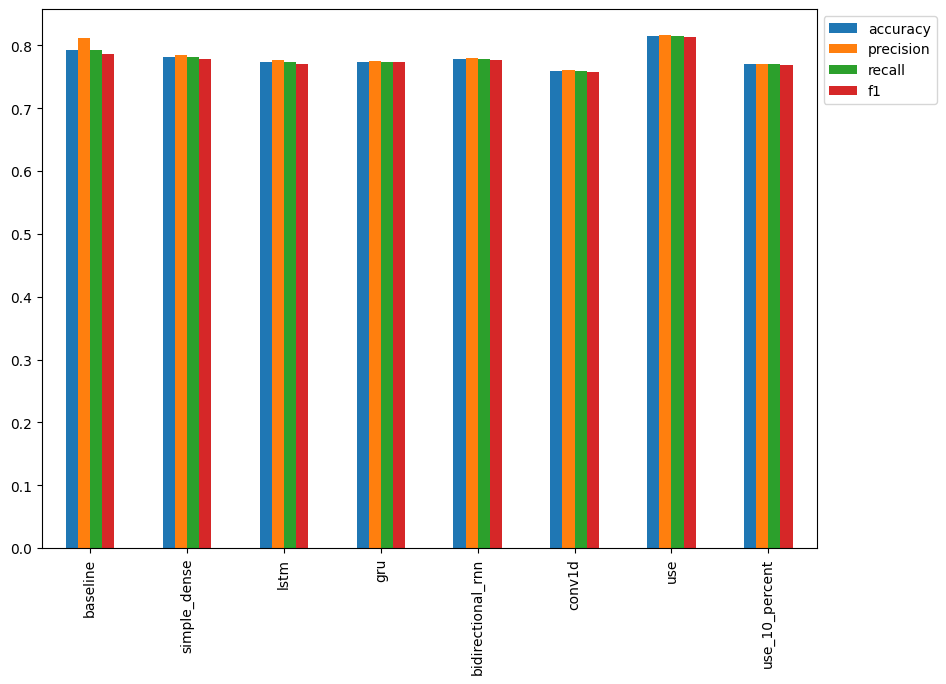

In [127]:
# Plot and compare all of the models results
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.,1.));